## 의도(intent) 분류 모델 제작(Colab GPU)


In [2]:
# GPU 런타임 환경 설정

# 보안 문제로 ipynb 파일 open시마다 실행
from google.colab import drive
drive.mount('/content/drive') # 마운트 이름은 자유롭게 지정 가능

Mounted at /content/drive


In [3]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 453 kB 59.4 MB/s 


In [4]:
import os
import time
import pandas as pd
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Conv1D, GlobalMaxPool1D, concatenate
from tensorflow.keras.utils import plot_model   # 네트워크 입출력 시각화
from tensorflow.keras.callbacks import EarlyStopping # 학습 자동 중지

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 

if (platform.system() == 'Windows'):  # Windows, Linux, Darwin
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/NLP/chatbot/models/intent/' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------

os.chdir('../../')
from utils.Preprocess import Preprocess
from config.GlobalParams import MAX_SEQ_LEN
os.chdir('./models/intent/')      
print('MAX_SEQ_LEN:', MAX_SEQ_LEN)

MAX_SEQ_LEN: 15


In [2]:
# 데이터 읽어오기
train_file = "./total_train_data.csv"
data = pd.read_csv(train_file, delimiter=',') # 안부 인사드립니다.,0
queries = data['query'].tolist()  # 안부 인사드립니다.
intents = data['intent'].tolist() # 0

p = Preprocess(word2index_dic='../../dict/chatbot_dict.bin',
               userdic='../../dict/user_dic.tsv')

In [3]:
# 단어 시퀀스 생성 test
sentence = queries[0]
pos = p.pos(sentence) # 품사 태깅
print('pos:', pos)
keywords = p.get_keywords(pos, without_tag=True) # 단어만 추출
print('keywords:', keywords)
seq = p.get_wordidx_sequence(keywords) # 키워드를 단어 인덱스 시퀀스로 변환
print('seq:', seq)

pos: [('헬로우', 'NNG')]
keywords: ['헬로우']
seq: [9422]


In [4]:
# 단어 시퀀스 생성 test, 문장을 수치화 테스트 
sequences = []
for sentence in queries[0:5]:
    pos = p.pos(sentence) # 품사 태깅
    keywords = p.get_keywords(pos, without_tag=True)
    seq = p.get_wordidx_sequence(keywords)
    sequences.append(seq)
    
print(sequences)    

[[9422], [6708], [2967, 1051, 66], [684, 1051, 2, 567, 896, 684, 1051, 8, 149, 1135], [684, 1051, 2, 567, 666, 684, 1051, 8, 732, 162]]


In [5]:
# 입력 차원 통일
# 단어 시퀀스 벡터 크기가 15임으로 15가 안되는 문장 0으로 padding
padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')
print(padded_seqs[0:5])

[[9422    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [6708    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [2967 1051   66    0    0    0    0    0    0    0    0    0    0    0
     0]
 [ 684 1051    2  567  896  684 1051    8  149 1135    0    0    0    0
     0]
 [ 684 1051    2  567  666  684 1051    8  732  162    0    0    0    0
     0]]


In [6]:
# 단어 시퀀스 생성, Colab: 32s
sequences = []
for sentence in queries:
    pos = p.pos(sentence) # 품사 태깅
    keywords = p.get_keywords(pos, without_tag=True) # 토큰만 분리
    seq = p.get_wordidx_sequence(keywords) # 토큰을 숫자로 변경
    sequences.append(seq) # 숫자 저장

In [7]:
print(sequences[0:5]) # 5개의 문장만 확인

[[9422], [6708], [2967, 1051, 66], [684, 1051, 2, 567, 896, 684, 1051, 8, 149, 1135], [684, 1051, 2, 567, 666, 684, 1051, 8, 732, 162]]


In [8]:
# 단어 인덱스 시퀀스 벡터 ○2
# 단어 시퀀스 벡터 크기
padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

# (105658, 15)
print(padded_seqs.shape)
print(len(intents)) #105658

(105658, 15)
105658


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 128)      2272256     ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 15, 128)      0           ['embedding[0][0]']              
                                                                                                  
 conv1d (Conv1D)                (None, 13, 128)      49280       ['dropout[0][0]']                
                                                                                              

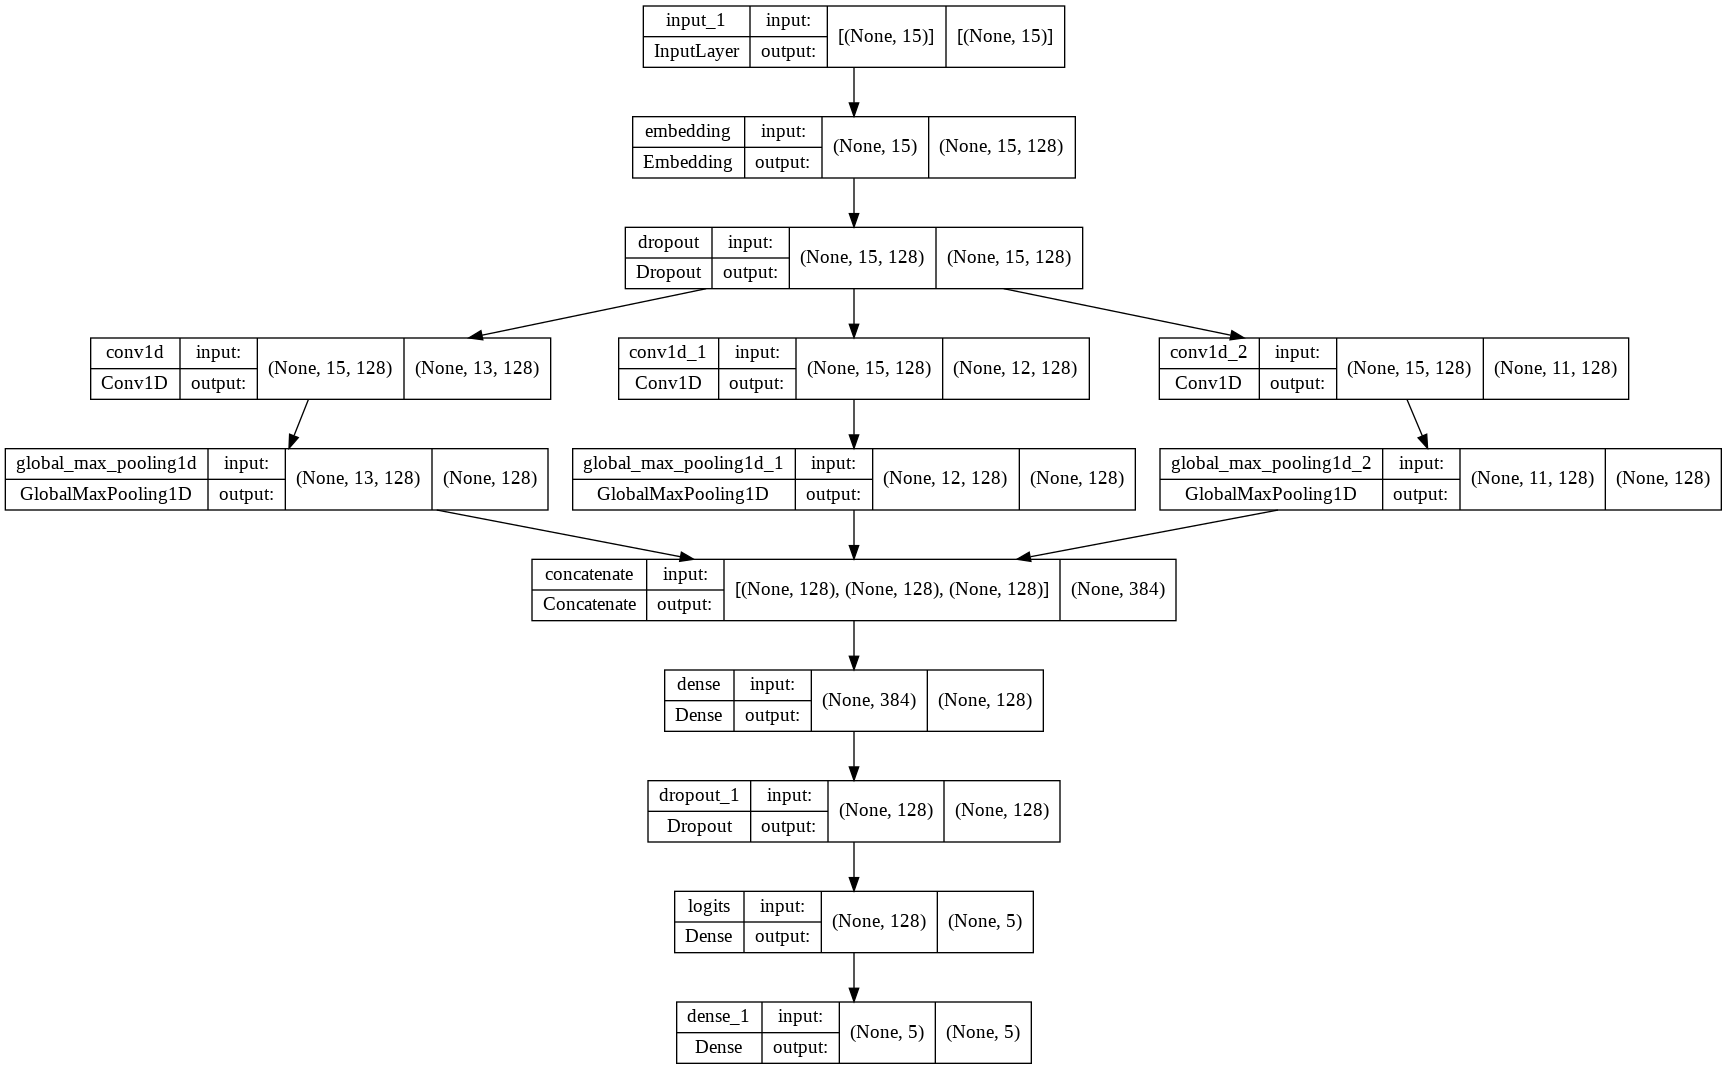

In [9]:
# 학습용, 검증용, 테스트용 데이터셋 생성 ○3
# 학습셋:검증셋:테스트셋 = 7:2:1
ds = tf.data.Dataset.from_tensor_slices((padded_seqs, intents))
ds = ds.shuffle(len(queries))

train_size = int(len(padded_seqs) * 0.7)
val_size = int(len(padded_seqs) * 0.2)
test_size = int(len(padded_seqs) * 0.1)

train_ds = ds.take(train_size).batch(10)
val_ds = ds.skip(train_size).take(val_size).batch(10)
test_ds = ds.skip(train_size + val_size).take(test_size).batch(10)

# 하이퍼 파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 5
VOCAB_SIZE = len(p.word_index) + 1 #전체 단어 개수


# CNN 모델 정의  ○4
input_layer = Input(shape=(MAX_SEQ_LEN,))
embedding_layer = Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_SEQ_LEN)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

conv1 = Conv1D(
    filters=128,
    kernel_size=3,
    padding='valid',
    activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)

conv2 = Conv1D(
    filters=128,
    kernel_size=4,
    padding='valid',
    activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)

conv3 = Conv1D(
    filters=128,
    kernel_size=5,
    padding='valid',
    activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

# 3,4,5gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])

hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(5, name='logits')(dropout_hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)


# 모델 생성  ○5
model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
plot_model(model, to_file='./train_model.png', show_shapes=True, show_layer_names=True)

In [10]:
# 모델 학습 ○6
start = time.time()

# 학습의 자동 종료(patience=5: 학습 결과가 개선되지 않아도 학습을 진행할 횟수)
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

hist = model.fit(train_ds, validation_data=val_ds, epochs=EPOCH, verbose=1, callbacks=[es])
print('Time:', time.time() - start)  # i5 8500: 531, Colab GPU: 299

# 모델 평가(테스트 데이터 셋 이용) ○7
loss, accuracy = model.evaluate(test_ds, verbose=1)
print('Accuracy: %f' % (accuracy * 100))
print('loss: %f' % (loss))

# 모델 저장  ○8
model.save('./intent_model.h5')

Epoch 1/5
7396/7396 [==============================] - 60s 8ms/step - loss: 0.0422 - accuracy: 0.9872 - val_loss: 0.0112 - val_accuracy: 0.9934
Epoch 2/5
7396/7396 [==============================] - 44s 6ms/step - loss: 0.0155 - accuracy: 0.9947 - val_loss: 0.0067 - val_accuracy: 0.9973
Epoch 3/5
7396/7396 [==============================] - 44s 6ms/step - loss: 0.0118 - accuracy: 0.9953 - val_loss: 0.0064 - val_accuracy: 0.9948
Epoch 4/5
7396/7396 [==============================] - 44s 6ms/step - loss: 0.0101 - accuracy: 0.9962 - val_loss: 0.0062 - val_accuracy: 0.9975
Epoch 5/5
7396/7396 [==============================] - 43s 6ms/step - loss: 0.0093 - accuracy: 0.9964 - val_loss: 0.0072 - val_accuracy: 0.9974
Time: 234.82940077781677
1057/1057 [==============================] - 3s 3ms/step - loss: 0.0065 - accuracy: 0.9978
Accuracy: 99.782300
loss: 0.006491


In [1]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()   # 오른쪽 y 축 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 0.02]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1]) # 0.0, 1: 0 ~ 100 %, 정확도임으로 변경하지 않음

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

NameError: ignored

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import preprocessing

intent_labels = {0: "인사", 1: "욕설", 2: "주문", 3: "예약", 4: "기타"}

# 의도 분류 모델 불러오기
model = load_model('./intent_model.h5')

In [6]:
query = "오늘 탕수육 주문 가능한가요?"
# query = "안녕하세요?"
from utils.Preprocess import Preprocess
p = Preprocess(word2index_dic='../../dict/chatbot_dict.bin',
               userdic='../../user_dic.tsv')
pos = p.pos(query)
print('pos:', pos)
keywords = p.get_keywords(pos, without_tag=True)
print('keywords:', keywords)
seq = p.get_wordidx_sequence(keywords)
print('seq:', seq)
sequences = [seq]
print('sequences:', sequences)

pos: [('오늘', 'NNG'), ('탕수육', 'NNP'), ('주문', 'NNP'), ('가능', 'XR'), ('하', 'XSA'), ('ㄴ가요', 'EF'), ('?', 'SF')]
keywords: ['오늘', '탕수육', '주문', '가능']
seq: [40, 431, 3, 6]
sequences: [[40, 431, 3, 6]]


In [7]:
# 단어 시퀀스 벡터 크기: 15 
from config.GlobalParams import MAX_SEQ_LEN
padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')
print('padded_seqs:', padded_seqs)
predict = model.predict(padded_seqs)
predict_class = tf.math.argmax(predict, axis=1) # (1, 5): 하나의 행안에서 열중에서 가장 큰 값

print(query)
print("의도 예측 점수: ", predict)
print("predict.shape:", predict.shape)
print("predict_class: ", predict_class)
print("의도 예측 클래스: ", predict_class.numpy())
print("의도: ", intent_labels[predict_class.numpy()[0]])

padded_seqs: [[ 40 431   3   6   0   0   0   0   0   0   0   0   0   0   0]]
오늘 탕수육 주문 가능한가요?
의도 예측 점수:  [[4.5328366e-24 8.0535234e-29 1.0000000e+00 1.8156581e-13 4.3753630e-24]]
predict.shape: (1, 5)
predict_class:  tf.Tensor([2], shape=(1,), dtype=int64)
의도 예측 클래스:  [2]
의도:  주문


In [8]:
from utils.Preprocess import Preprocess
from config.GlobalParams import MAX_SEQ_LEN

query = "안녕하세요?"
p = Preprocess(word2index_dic='../../dict/chatbot_dict.bin',
               userdic='../../user_dic.tsv')
pos = p.pos(query)
keywords = p.get_keywords(pos, without_tag=True)
print('keywords:', keywords)
seq = p.get_wordidx_sequence(keywords)
print('seq:', seq)
sequences = [seq]
print('sequences:', sequences)

padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

predict = model.predict(padded_seqs)
predict_class = tf.math.argmax(predict, axis=1)
print(query)
print("의도 예측 점수 : ", predict)
print("의도 예측 클래스 : ", predict_class.numpy())
print("의도  : ", intent_labels[predict_class.numpy()[0]])

keywords: ['안녕하세요']
seq: [353]
sequences: [[353]]
안녕하세요?
의도 예측 점수 :  [[0.6397398  0.04100597 0.06333052 0.1161913  0.13973242]]
의도 예측 클래스 :  [0]
의도  :  인사


In [9]:
from utils.Preprocess import Preprocess
from config.GlobalParams import MAX_SEQ_LEN

query = "내일 오전에 주문 가능해요?"
pos = p.pos(query)
keywords = p.get_keywords(pos, without_tag=True)
seq = p.get_wordidx_sequence(keywords)
sequences = [seq]

padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

predict = model.predict(padded_seqs)
predict_class = tf.math.argmax(predict, axis=1)
print(query)
print("의도 예측 점수 : ", predict)
print("의도 예측 클래스 : ", predict_class.numpy())
print("의도  : ", intent_labels[predict_class.numpy()[0]])

내일 오전에 주문 가능해요?
의도 예측 점수 :  [[8.7460221e-21 2.2894215e-25 1.0000000e+00 5.4479932e-12 7.2612523e-21]]
의도 예측 클래스 :  [2]
의도  :  주문


In [10]:
from utils.Preprocess import Preprocess
from config.GlobalParams import MAX_SEQ_LEN

query = "내일 오전 10시에 예약 가능해요?"
pos = p.pos(query)
keywords = p.get_keywords(pos, without_tag=True)
seq = p.get_wordidx_sequence(keywords)
sequences = [seq]

padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

predict = model.predict(padded_seqs)
predict_class = tf.math.argmax(predict, axis=1)
print(query)
print("의도 예측 점수 : ", predict)
print("의도 예측 클래스 : ", predict_class.numpy())
print("의도  : ", intent_labels[predict_class.numpy()[0]])

내일 오전 10시에 예약 가능해요?
의도 예측 점수 :  [[1.6034416e-20 2.0588579e-22 7.3978532e-05 9.9992597e-01 3.3094225e-19]]
의도 예측 클래스 :  [3]
의도  :  예약
